## 小説家になろう ブクマ数予測 \~”伸びる”タイトルとは？\~ チュートリアル

このnotebookは、Nishikaコンペティション [小説家になろう ブクマ数予測 \~”伸びる”タイトルとは？\~](https://www.nishika.com/competitions/21/summary) のチュートリアルです。

コンペタイトルにもある通り、「小説タイトル」「小説あらすじ」といったテキストデータから得られる情報がブクマ数予測に効くか？というのが、1つのテーマです。

そこで本notebookでは、特にテキストデータからの特徴量作成に焦点を当てます。<br>
例えば、タイトルが短くまとまっている作品に良作品が多い、などの傾向があるかもしれません（「[無職転生](https://ncode.syosetu.com/n9669bk/)」「[俺は星間国家の悪徳領主！](https://ncode.syosetu.com/n1976ey/)」などが好きな私による全くの主観です）。

もちろん、精度向上には構造化データによる特徴量作成も効果的ですので、色々試してみましょう！<br>
（構造化データからの特徴量作成は、[こちらのチュートリアル](https://colab.research.google.com/drive/1uGESzJFtzbDwGSq9Jk1w4QhtrPjP5XqY?usp=sharing)などをご覧ください）

| 要素 | 説明 |
| ---- | ---- |
|ncode | Nコード|
|general_firstup | 初回掲載日 YYYY-MM-DD HH:MM:SSの形式|
|title | 小説名|
|story | 小説のあらすじ|
|keyword | キーワード|
|userid | 作者のユーザID(数値)|
|writer | 作者名|
|biggenre | 大ジャンル|
|genre | ジャンル|
|novel_type | 連載の場合は1、短編の場合は2|
|end | 短編小説と完結済小説は0となっています。連載中は1です。|
|isstop | 長期連載停止中なら1、それ以外は0です。|
|isr15 | 登録必須キーワードに「R15」が含まれる場合は1、それ以外は0です。|
|isbl | 登録必須キーワードに「ボーイズラブ」が含まれる場合は1、それ以外は0です。|
|isgl | 登録必須キーワードに「ガールズラブ」が含まれる場合は1、それ以外は0です。|
|iszankoku | 登録必須キーワードに「残酷な描写あり」が含まれる場合は1、それ以外は0です。|
|istensei | 登録必須キーワードに「異世界転生」が含まれる場合は1、それ以外は0です。|
|istenni | 登録必須キーワードに「異世界転移」が含まれる場合は1、それ以外は0です。|
|pc_or_k | 1はケータイのみ、2はPCのみ、3はPCとケータイで投稿された作品です。<br>対象は投稿と次話投稿時のみで、どの端末で執筆されたかを表すものではありません。|
|fav_novel_cnt_bin | ブックマーク度|

ドライブをマウント（左側サイドバーから実行）

package install

In [1]:
!pip install xfeat >> /dev/null
!pip install ginza ja-ginza >> /dev/null

In [1]:
import spacy
nlp = spacy.load('ja_ginza')
from xfeat import Pipeline, SelectCategorical, LabelEncoder

In [51]:
!pip install category-encoders

     |████████████████████████████████| 80 kB 2.4 MB/s 


ランタイムを再起動（再起動しないとja_ginzaのloadでエラー）

In [52]:
import category_encoders as ce

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
from collections import Counter

In [3]:
import json
import pickle
import re
from glob import glob
from tqdm import tqdm

import regex
import pandas as pd
pd.set_option("max_rows", 500, "max_colwidth", 500, "max_columns", 500, "display.unicode.east_asian_width", True)
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer

### ファイル読み込み・データ確認

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
cd drive/MyDrive/Colab\ Notebooks/nishika-novel-bookmark/data

/content/drive/MyDrive/Colab Notebooks/nishika-novel-bookmark/data


In [6]:
ls

 bert_feature_df.csv        sample_submission.csv   train.csv
'~$data_explanation.xlsx'   test.csv
 data_explanation.xlsx      test_submission.csv


In [69]:
train_df = pd.read_csv('train.csv', parse_dates=["general_firstup"])
test_df = pd.read_csv('test.csv', parse_dates=["general_firstup"])
sub_df = pd.read_csv('sample_submission.csv')

In [70]:
print(train_df.shape, test_df.shape)
print(train_df.isnull().sum())
print(test_df.isnull().sum())


(40000, 20) (8522, 19)
ncode                   0
general_firstup         0
title                   0
story                   0
keyword              2226
userid                  0
writer                  0
biggenre                0
genre                   0
novel_type              0
end                     0
isstop                  0
isr15                   0
isbl                    0
isgl                    0
iszankoku               0
istensei                0
istenni                 0
pc_or_k                 0
fav_novel_cnt_bin       0
dtype: int64
ncode                0
general_firstup      0
title                0
story                0
keyword            645
userid               0
writer               0
biggenre             0
genre                0
novel_type           0
end                  0
isstop               0
isr15                0
isbl                 0
isgl                 0
iszankoku            0
istensei             0
istenni              0
pc_or_k              0
dtype: 

In [71]:
keyword_fillna_dict = {"keyword": "keyword_none"}
train_df.fillna(keyword_fillna_dict, inplace=True)
test_df.fillna(keyword_fillna_dict, inplace=True)

In [10]:
train_df.head()

,ncode,general_firstup,title,story,keyword,userid,writer,biggenre,genre,novel_type,end,isstop,isr15,isbl,isgl,iszankoku,istensei,istenni,pc_or_k,fav_novel_cnt_bin
0,N7588B,2007-04-01 16:40:57,暗い窓辺と皇帝の北の宮,※新しく手直ししました。\n\nhttp://ncode.syosetu.com/n2539l/\n\n宇宙開拓地の入植農家の子供として、小人の「僕」が生まれる。両親は我が子として受け入れようとし、飼い猫のロマノフも「僕」の世話をしてくれる。しかし、子供達は受け入れてはくれず、やがて、子供達の意地悪により、ロマノフも死んでしまう。両親は家庭教師として、宇宙開拓局の役人だったクリスを迎える。「僕」は彼の授業の中で学ぶ楽しみを見付けて行くが、彼はやがて地球政府と革命軍の戦いの為「僕」の元を去っていく。,ファンタジー SF 天使 小人 猫,9904,梅田浩志,4,402,1,0,0,0,0,0,0,0,0,0,1
1,N8726B,2007-04-22 15:40:30,仮想現実ゲーム 『ヴァルハラ』,ゲームセンターの片隅に置かれた律儀なまでにリアルなゲーム、ヴァルハラ。それはプレイを重ねるたびに俺たちを魅了していった。そして今日も勇士《エイン》たちの戦いは終わらない。――戦場で育まれる戦友達の友情を描いたSFバトル×バトル,仮想現実 ゲーム バトル 戦乙女 高校生 学校/学園 アンドロイド ライト SF エンターテイメント ハイテク 友情 現代(モダン) 未来,6527,ルト,4,401,1,0,0,0,0,0,0,0,0,3,2
2,N5481C,2007-08-22 18:25:54,海の竜騎兵,海軍の中に存在するクジラ部隊「竜騎兵」 主人公はその一員だ。\n騎乗する鯨との間に結ばれた絆は強く、主人公の戦闘能力も次第に洗練されてゆく。\n敵国にライバルが出現。新兵器の登場。\nすばしっこく泳ぐ鯨に魚雷が命中するわけもなく、戦闘は自然と白兵戦になる。\n,ヒーロー 冒険 海軍 深海 海中の戦闘 HJ2021,13882,雨宮雨彦,4,403,1,0,0,0,0,0,0,0,0,0,3
3,N6260C,2007-09-06 21:33:37,宇宙狂時代,はるか未来、宇宙船メーカー「ペガサス」のわずか十八才の社長でもあり、美少女でもあるミリィは、前代未聞の宇宙船によるレースを計画する。ライバル社の「クロノス」に打ち勝つため、なんとみずから宇宙船を操縦しようと言うのだ。彼女は勝利をつかむことができるだろうか？,冒険 ロケット ロボット サイボーグ レース コメディ SF エンターテイメント 少女 友情 少年 未来 宇宙,13920,万卜人,4,402,1,0,0,0,0,0,0,0,0,2,1
4,N6903C,2007-09-17 01:02:33,クライムズ クライシス,アメリカの大富豪テッドマクシミリアン。心筋梗塞を患った彼があの世に旅立った。弁護士が開いた遺書に書かれていたのはオンラインゲームクライムズを最初にクリアーした者に全財産を与えるというものだった。しかし、この遺産にはとんでもない物が含まれていた！。フェア公正とは何か？。テッドマクシミリアンが仕掛けた不公正に対する抗議がゲームスタートと共に大事件に発展する！！,ゲーム フェア 平和 権力 ドキドキ シリアス ハッピーエンド 国家/民族 友情 OL/サラリーマン 刑事 現代(モダン),12136,武上 渓,4,401,1,0,0,0,0,0,0,0,0,1,1


# EDA

### fav_novel_cnt_bin

In [11]:
train_df.fav_novel_cnt_bin.value_counts()
# binの幅は？
# 0: 0, 1: 0~10, 2: 11~100, 3: 101~1000, 4: 1000~

0    18646
1    14363
2     4320
3     1857
4      814
Name: fav_novel_cnt_bin, dtype: int64

In [12]:
train_df.query("fav_novel_cnt_bin == 4").sample(5)

,ncode,general_firstup,title,story,keyword,userid,writer,biggenre,genre,novel_type,end,isstop,isr15,isbl,isgl,iszankoku,istensei,istenni,pc_or_k,fav_novel_cnt_bin
7779,N4672FF,2019-01-01 05:05:35,魔法使いは、喋る伝説の聖剣を拾って旅に出る……魔術書も買わずに。,★★改稿作業中です★★\n★★タイトル変更しました★★\n\n≪もしも、魔術書を買うお金もない駆け出し魔法使いが、伝説の聖剣を拾ったら……？≫\n\nモンスター討伐の冒険者「バスター」を目指す魔法少年シークは、ある日森で立派な剣を見つけた。\nけれど、魔法使いになるのに剣はちょっと……と元の場所に置いて帰ろうとしたら。\n\n「よし、見なかった事にしよう。俺にはどうしようもない」\n「はい!? ちょっと、ちょっと、まさか置いていくつもりかい？」\n\nえっ？ 今、剣が喋った!?\nしかも元の持ち主は300年前の伝説の勇者だったと言いだして……!?\n\nああでもない、こうでもないとおだやかな掛け合いを見せつつ、\n拾ってしまったがために聖剣バルドルに言われるがまま剣術で戦うシーク。\n\n色んな人と出会い、色んな場所を巡り、冒険の中でモンスターとの死闘を繰り広げる。\n\nそうして他人よりお人好し過ぎるだけだった純朴田舎少年シークは、\nいつしか仲間と共に英雄と呼ばれるようになっていた……。\n\n\nこの物語は魔法を使いたい魔法使いと、剣術で戦わせたい喋る伝説の聖剣が共に旅を...,残酷な描写あり 冒険 男主人公 剣と魔法 現地主人公 勇者 成り上がり 努力してコンビで強く 相棒 旅 無機物 覚醒 ESN大賞３ 123大賞 OVL大賞7M 新人発掘コンテスト,1304476,桜良 壽ノ丞,2,201,1,0,0,0,0,0,1,0,0,2,4
4336,N6771DP,2016-10-31 19:46:39,セカンド・ストーリー・オンライン 理想の魔女目指して頑張ります。,\n\n――二つ目の物語を求める人へ。\n\n人々を救う勇者から絶望を振りまく魔王や魔物。\nはたまた何の取り柄もない村人。この世界ではどんな人にも存在にもなれます。\nさぁあなたの二つ目の物語を始めましょう。\nあなたが紡ぎ出す物語がSecond・Story・Onlineの歴史なのですから――。\n\nキャッチコピーと共にそのゲームはベータテストを終えサービスを開始した。\n他のVRMMOとそう変わらないファンタジー系のオンラインゲームという印象。\n少し違うとすれば、ロールプレイヤーの人口が多いこと。\n\n私もそんなゲームのプレイヤー。しかもロールプレイヤーです。\n魔女に対する憧れでこのゲームをプレイしたのがきっかけ。\nさぁ今日も理想の魔女を目指してロールプレイを頑張りましょう。\n\nほんのりロールプレイヤーことクロエさんが理想の魔女を目指して頑張るが……理想とはちょっとズレている模様。\n\n近未来の世界にあるロール推奨VRMMOの中で、主人公とロールプレイヤーなど様々な人達を中心としたシリアスでコメディな物語です。...,残酷な描写あり 近未来 VRMMO 女主人公 魔法 森の魔女 従者はオーク 使い魔 ミミズク 黒猫 ロールプレイヤー シリアス と思いきやコメディ Gzゲーム小説コン,515527,彩帆,4,401,1,0,0,0,0,0,1,0,0,2,4
9515,N3708FP,2019-07-02 20:23:39,僕は婚約破棄なんてしませんからね,僕の婚約者となる、おないどしの公爵令嬢との初顔合わせで、ご令嬢、僕を見るなりいきなり悲鳴を上げて倒れちゃいました！ ええええ！？ なんで――――！？\n え、思い出した？ 君が悪役令嬢？ 僕の浮気のせいで君が破滅する？ いや十歳の僕にそんなこと泣きながら言われましてもね……。ひどいなその設定の僕。\n でもね、そんなことにならないように、できることはいっぱいあるはずだよ。僕と一緒に考えようよ！\n ほら、僕を信じて。\n\n これは乙女ゲーのストーリーという過酷な運命にラブラブしながら抗い、イチャイチャしながらゲームの強制力と戦う、十歳から始まる王子と悪役令嬢の恋物語。\n※完結済※【三巻完結編 ９月２日より一迅社ノベルズ様より発売！ ゼロサムオンライン様よりコミカライズ公開中！】\n※Ｗｅｂ版追加エピソード「ボツになった展開集」を追加しています。\n ゲームらしいマルチエンディング方式のＩＦストーリーです。...,異世界転生 乙女ゲーム 悪役令嬢 ラブコメ 主人公は王子 婚約破棄(全力回避) ラブラブ ほのぼの 転生悪役令嬢 現代知識チート ハッピーエンド 完結済 追加エピソードあり 書籍化 コミカライズ ボツになった展開集,1051336,ジュピタースタジオ,1,101,1,0,0,0,0,0,0,1,0,2,4
19058,N6441GT,2021-02-02 19:16:21,蛮族の王子様 ～指先王子、女族長に婿入りする～,\n 聖国フロンサードの第四王子レインティエ・クスノ・フロンサード。十七歳。\n とある理由から国に居づらくなった彼は、西に広がる霊海の森の先に住む|白蛇《エ・ラジャ》族の女族長に婿入りすることを決意する。\n\n 一方、森を隔てた向こうの|白蛇《エ・ラジャ》族。\n\n 女族長アーレ・エ・ラジャは、一年前に「我が夫にするための最高の男」を所望したことを思い出し、婿を迎えに行くべく動き出す。\n\n \n こうして、本来なら出会うことのない、生まれも育ちもまったく違う一組の男女が出会う。 \n,残酷な描写あり 日常 ラブコメ ギャグ コメディ 夫婦 HJ2021 集英社小説大賞2 OVL大賞7 ESN大賞３ がうがうコン1,215441,南野海風,1,101,1,0,0,0,0,0,1,0,0,2,4
1240,N0728CY,2015-10-22 20:01:51,職業リア充の異世界無双。,いつも通りの日常を送っていたガチオタ主人公、芝崎優斗のクラスに、突然光が降り注ぐ。そして目を開いたらそこには森が広がっていた。チート能力を持ってるかと思い、いつの間にか持っていた支給品で職業を確認すると、なんと最も弱いと言われている『魔物使い』だった。『魔物使い』であるが故に、城をクラスメイトの川口舞と共に追い出された優斗は…………。\n突然転送された主人公がリア充になって、最弱と言われる『魔物使い』で妻と共に異世界を無双していく異世界物です。\n付き合っていても結婚していても等しくリア充です。\n僕の中では。\nそこのところ、よろしくお願いします。\nハーレム要素を含まないことにしました。\n矛盾の無い方向転換をしたいと思います。\n最初は進展があまり無いです。第二章から動き始めます。 \n高校一年生の書いた処女作です。暖かく見守ってやってください！\n12/20日間ランキングに乗りました！\n234→122→107→67→9→3 3位に入れるなんて夢のようです！皆様ありがとうございます(≧∇≦)\n2/17）修...,R15 残酷な描写あり 異世界無双 恋愛 リア充爆発しろ チート 主人公魔物使い 妻精霊使い 成り上がり クラス転移 主人公英雄化 主人公直に最強 最終神倒し？ ハーレムに見せかけて 妻一筋 冒険者 改革,693992,すみを。,98,9801,1,0,0,1,0,0,1,0,0,2,4


### NCODE 小説ID

In [13]:
# IDで一意のため使わない
train_df.ncode.unique().shape[0] == train_df.shape[0]

True

### general_firstup 初回掲載日

In [14]:
print(train_df.general_firstup.min(), "~", train_df.general_firstup.max())
print(test_df.general_firstup.min(), "~", test_df.general_firstup.max())
# 結構昔のデータある => 除去すべき？

2007-04-01 16:40:57 ~ 2021-08-12 08:00:00
2021-08-12 08:00:00 ~ 2021-09-23 21:43:34


In [15]:
# 年度ごとのtargetの分布の違い
print(train_df.general_firstup.dt.year.value_counts())
pd.crosstab(train_df.general_firstup.dt.year, train_df.fav_novel_cnt_bin, margins=True, normalize='index')

2021    22252
2020     6609
2019     3367
2016     3115
2018     2330
2017      971
2015      499
2014      330
2013      213
2012      143
2011       72
2010       40
2008       28
2009       22
2007        9
Name: general_firstup, dtype: int64


fav_novel_cnt_bin,0,1,2,3,4
general_firstup,,,,,
2007,0.111111,0.666667,0.111111,0.111111,0.000000
2008,0.214286,0.535714,0.214286,0.035714,0.000000
2009,0.045455,0.863636,0.045455,0.045455,0.000000
2010,0.200000,0.450000,0.250000,0.050000,0.050000
2011,0.236111,0.375000,0.208333,0.138889,0.041667
2012,0.139860,0.377622,0.230769,0.139860,0.111888
2013,0.159624,0.347418,0.230047,0.140845,0.122066
2014,0.151515,0.345455,0.293939,0.133333,0.075758
2015,0.226453,0.384770,0.236473,0.106212,0.046092


In [16]:
# 季節性はあるか？ 冬シーズンは読まれやすいなど
print(train_df.general_firstup.dt.month.value_counts())
pd.crosstab(train_df.general_firstup.dt.month, train_df.fav_novel_cnt_bin, margins=True, normalize='index')

7     7746
6     5521
5     5332
4     4456
8     3760
3     2817
1     2327
12    2111
2     1917
11    1386
9     1323
10    1304
Name: general_firstup, dtype: int64


fav_novel_cnt_bin,0,1,2,3,4
general_firstup,,,,,
1,0.352385,0.466695,0.110013,0.048560,0.022346
2,0.417319,0.368284,0.127282,0.056860,0.030256
3,0.475328,0.340433,0.110401,0.048278,0.025559
4,0.547127,0.317998,0.081463,0.038151,0.015260
5,0.546324,0.313391,0.090210,0.035446,0.014629
6,0.483065,0.345952,0.105778,0.045282,0.019924
7,0.489672,0.345598,0.101730,0.049058,0.013943
8,0.446011,0.367021,0.110904,0.050798,0.025266
9,0.368859,0.390023,0.146636,0.068783,0.025699


In [17]:
# 曜日ごと
print(train_df.general_firstup.dt.day_name().value_counts())
pd.crosstab(train_df.general_firstup.dt.day_name(), train_df.fav_novel_cnt_bin, margins=True, normalize='index')

Sunday       6819
Saturday     6298
Monday       5673
Friday       5425
Wednesday    5369
Thursday     5266
Tuesday      5150
Name: general_firstup, dtype: int64


fav_novel_cnt_bin,0,1,2,3,4
general_firstup,,,,,
Friday,0.474286,0.349309,0.104516,0.047373,0.024516
Monday,0.476996,0.356954,0.105059,0.043716,0.017275
Saturday,0.448079,0.368530,0.117339,0.046840,0.019212
Sunday,0.456372,0.369996,0.108667,0.046634,0.018331
Thursday,0.456134,0.361945,0.112609,0.046335,0.022978
Tuesday,0.484854,0.344272,0.104854,0.043883,0.022136
Wednesday,0.471969,0.357608,0.101322,0.050102,0.018998
All,0.466150,0.359075,0.108000,0.046425,0.020350


### keyword

fav_novel_cnt_bin
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
4    AxesSubplot(0.125,0.125;0.775x0.755)
Name: keyword_count, dtype: object

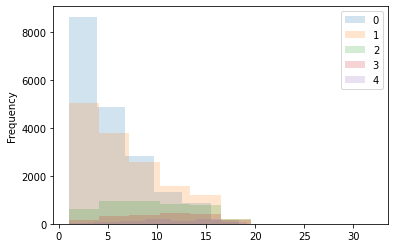

In [19]:
train_df["keyword_count"] = train_df.keyword.str.replace("\u3000", " ").str.split(" ").str.len()
train_df.groupby("fav_novel_cnt_bin")["keyword_count"].plot.hist(legend=True, alpha=0.2)

In [20]:
keyword_counter = Counter(" ".join(train_df.keyword.astype("str").str.replace("\u3000", "").to_list()).split(" "))
print("キーワードの語彙数", len(keyword_counter.keys()))
keyword_counter.most_common(n=100)

キーワードの語彙数 39654


[('R15', 9724),
 ('日常', 8769),
 ('残酷な描写あり', 8344),
 ('男主人公', 5183),
 ('現代', 4636),
 ('青春', 4360),
 ('シリアス', 3858),
 ('近未来', 3677),
 ('女主人公', 3637),
 ('ほのぼの', 3295),
 ('ミステリー', 2801),
 ('ハッピーエンド', 2727),
 ('冒険', 2689),
 ('keyword_none', 2226),
 ('ギャグ', 2134),
 ('ラブコメ', 2075),
 ('異能力バトル', 2038),
 ('魔法', 1837),
 ('恋愛', 1816),
 ('未来', 1679),
 ('オリジナル戦記', 1593),
 ('怪談', 1581),
 ('ダーク', 1563),
 ('時代小説', 1537),
 ('サスペンス', 1515),
 ('異世界転移', 1456),
 ('私小説', 1441),
 ('異世界転生', 1380),
 ('ファンタジー', 1378),
 ('VRMMO', 1352),
 ('学園', 1312),
 ('伝奇', 1309),
 ('悲恋', 1306),
 ('西洋', 1278),
 ('ヒーロー', 1263),
 ('和風', 1125),
 ('SF', 1099),
 ('人工知能', 1079),
 ('人外', 1024),
 ('身分差', 968),
 ('サイコホラー', 963),
 ('短編', 956),
 ('スクールラブ', 952),
 ('チート', 909),
 ('ショートショート', 896),
 ('年の差', 893),
 ('ホームドラマ', 880),
 ('異世界', 872),
 ('ESN大賞３', 850),
 ('ディストピア', 837),
 ('探偵小説', 832),
 ('天災', 805),
 ('超能力', 803),
 ('ガールズラブ', 795),
 ('スペースオペラ', 792),
 ('夏のホラー2021', 792),
 ('ハードボイルド', 773),
 ('ネット小説大賞九感想', 762),
 ('ネット小説大賞九', 757)

In [21]:
# [(w, c) for w, c in keyword_counter.items() if c == 1]

In [22]:
len([w for w,c in keyword_counter.items() if c >= 10])

1668

### user_id

In [23]:
train_df.userid.value_counts()

980418     287
1141685    188
476078     180
874484     146
1599514    142
          ... 
697191       1
1868643      1
1678176      1
1467231      1
1974276      1
Name: userid, Length: 17731, dtype: int64

In [24]:
for d in train_df.userid.value_counts().head(10).items():
  print(d)

(980418, 287)
(1141685, 188)
(476078, 180)
(874484, 146)
(1599514, 142)
(1463156, 128)
(1066143, 123)
(677058, 120)
(1674118, 116)
(1574262, 113)


In [25]:
for user_id, write_count in train_df.userid.value_counts().head(10).items():
  print(user_id, "=>", train_df.query("userid == @user_id").fav_novel_cnt_bin.value_counts())

980418 => 0    257
1     30
Name: fav_novel_cnt_bin, dtype: int64
1141685 => 0    154
1     34
Name: fav_novel_cnt_bin, dtype: int64
476078 => 0    142
1     33
2      4
3      1
Name: fav_novel_cnt_bin, dtype: int64
874484 => 1    140
2      6
Name: fav_novel_cnt_bin, dtype: int64
1599514 => 0    125
1     17
Name: fav_novel_cnt_bin, dtype: int64
1463156 => 1    80
2    46
3     1
0     1
Name: fav_novel_cnt_bin, dtype: int64
1066143 => 0    83
1    40
Name: fav_novel_cnt_bin, dtype: int64
677058 => 0    119
1      1
Name: fav_novel_cnt_bin, dtype: int64
1674118 => 0    105
1     11
Name: fav_novel_cnt_bin, dtype: int64
1574262 => 0    104
1      9
Name: fav_novel_cnt_bin, dtype: int64


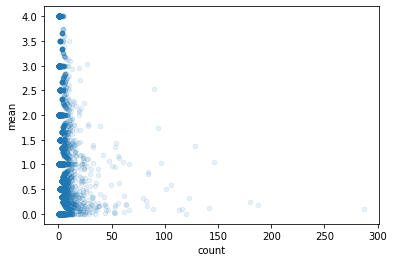

In [26]:
train_df.groupby("userid").fav_novel_cnt_bin.agg(["count", "mean"]).plot.scatter("count", "mean", alpha=0.1)

### writer

In [27]:
train_df.userid.unique().shape[0], train_df.writer.unique().shape[0]

(17731, 18254)

In [28]:
tmp = train_df.groupby("userid").writer.unique().reset_index()
tmp["writer_count"] = tmp.writer.str.len()
tmp.head()

,userid,writer,writer_count
0,3,[水無月冬弥],1
1,23,[earl gray],1
2,200,[水本爽涼],1
3,208,[葉月香],1
4,450,[他界],1


In [29]:
tmp.query("writer_count >= 10")

,userid,writer,writer_count
5512,815315,"[秋月渚, クラリオン, 長尾義明, 常夜, 奴, 網代陸, 麦茶, 糸乃蜘蛛, 坊主, 匿名, 皐月メイ, ぜんざい, 匿名希望, 亜鈴ゆずさ, そら豆, 平田貞彦, 日立無紗, 有明榮, 水彩度, 亜鈴 ゆずさ, 椎茸, 水仙, 俗物]",23
7208,1098859,"[みなはら, わたしの右手, すすむひと, あるいたりとまったり, 指し示す先, 匿名希望Ｍ, なにかのたまご, フィクションです, あさってに飛ばす, 幻を探すひと, 星に祈る, たくさん欲しいひと, まだまだこども, ちょっと夏バテ, 熱帯や～, 山へ行きたい, …不完全なるもの, クリエイターの端っこ, 思い出すとブルー]",19
8305,1275419,"[夏桜, ARIA, aika, LIKA, 海, 美琴, みこと, ゆゆ, ぴのこ, 深雪, rabbi, 完菜, 青崎, 神流, 完奈, 鈴音, 彩月, 和音, みさと, ゆうな, ゆうは, 夕菜, みいな, ゆうか, 美生, 由真, 凌子, 幸枝, かのん, 柚衣, 来夏, 真幌, 花音, RINO, 志信, 真幸, 未央, 真広, 美亜, 悠理, 由緒, あかり, まひろ, CIEL, 夕, ゆうこ, 叶多, Alice, Lir, 伊織, しお, 三日月, みおん, ALiCE, ありす, 栞, 七海]",57


In [30]:
train_df.query("userid == 815315")

,ncode,general_firstup,title,story,keyword,userid,writer,biggenre,genre,novel_type,end,isstop,isr15,isbl,isgl,iszankoku,istensei,istenni,pc_or_k,fav_novel_cnt_bin,keyword_count
13910,N6677GI,2020-07-03 12:52:36,引鉄,こんにちは。九州大学文藝部です。\n今年の春から、部誌のオンライン公開を行うことになりました。今回は新入生号をお届けします。楽しんでいただければ幸いです。\n九州大学文藝部の日々の活動はTwitterでご覧いただけます：https://twitter.com/kyudaibungei\nまた、カクヨムでも掲載しています。,九州大学文藝部,815315,秋月渚,3,304,2,0,0,0,0,0,0,0,0,2,0,1
13911,N6682GI,2020-07-03 13:01:45,天空の要塞狩り,こんにちは。九州大学文藝部です。\n今年の春から、部誌のオンライン公開を行うことになりました。今回は新入生号をお届けします。楽しんでいただければ幸いです。\n九州大学文藝部の日々の活動はTwitterでご覧いただけます：https://twitter.com/kyudaibungei\nまた、カクヨムでも掲載しています。,九州大学文藝部,815315,クラリオン,3,306,2,0,0,0,0,0,0,0,0,2,0,1
13912,N6689GI,2020-07-03 13:11:46,リセプション,こんにちは。九州大学文藝部です。\n今年の春から、部誌のオンライン公開を行うことになりました。今回は新入生号をお届けします。楽しんでいただければ幸いです。\n九州大学文藝部の日々の活動はTwitterでご覧いただけます：https://twitter.com/kyudaibungei\nまた、カクヨムでも掲載しています。,九州大学文藝部,815315,長尾義明,3,304,2,0,0,0,0,0,0,0,0,2,0,1
15433,N4836GN,2020-10-01 10:30:03,私達は私達に出来る事をした,こんにちは。九州大学文藝部です。\n今年の春から、部誌のオンライン公開を行うことになりました。今回は学祭号をお届けします。楽しんでいただければ幸いです。\n九州大学文藝部の日々の活動はTwitterでご覧いただけます：https://twitter.com/kyudaibungei\nまた、カクヨムでも掲載しています。,二次創作 九州大学文藝部,815315,クラリオン,4,404,2,0,0,0,0,0,0,0,0,2,0,2
19256,N0163GU,2021-02-09 22:15:15,戦死者を選ぶ者,こんにちは。九州大学文藝部です。\n今年の春から、部誌のオンライン公開を行うことになりました。今回は追い出し号をお届けします。楽しんでいただければ幸いです。\n九州大学文藝部の日々の活動はTwitterでご覧いただけます：https://twitter.com/kyudaibungei\nまた、カクヨムでも掲載しています。,九州大学文藝部,815315,クラリオン,2,202,2,0,0,0,0,0,0,0,0,2,0,1
22053,N9517GW,2021-04-06 15:19:34,その「すくい」の意味は,こんにちは。九州大学文藝部です。\n去年の春から、部誌のオンライン公開を行うことになりました。今回は新入生歓迎号をお届けします。\n新入生の皆様、ご入学おめでとうございます。ままならないことも多い現状ではありますが、どうか我が文藝部の作品が皆様の楽しみのひとつになれれば幸いです。\n九州大学文藝部の日々の活動はTwitterでご覧いただけます：https://twitter.com/kyudaibungei\nまた、カクヨムでも掲載しています。,九州大学文藝部,815315,常夜,2,202,2,0,0,0,0,0,0,0,0,2,1,1
22055,N9519GW,2021-04-06 15:20:26,引力のような力を肉体の内側からはたらかせる厄介な憂鬱で倦怠感にさいなまれる、あの瞬間,こんにちは。九州大学文藝部です。\n去年の春から、部誌のオンライン公開を行うことになりました。今回は新入生歓迎号をお届けします。\n新入生の皆様、ご入学おめでとうございます。ままならないことも多い現状ではありますが、どうか我が文藝部の作品が皆様の楽しみのひとつになれれば幸いです。\n九州大学文藝部の日々の活動はTwitterでご覧いただけます：https://twitter.com/kyudaibungei\nまた、カクヨムでも掲載しています。,九州大学文藝部,815315,奴,3,301,2,0,0,0,0,0,0,0,0,2,0,1
22056,N9520GW,2021-04-06 15:21:34,クレジット,こんにちは。九州大学文藝部です。\n去年の春から、部誌のオンライン公開を行うことになりました。今回は新入生歓迎号をお届けします。\n新入生の皆様、ご入学おめでとうございます。ままならないことも多い現状ではありますが、どうか我が文藝部の作品が皆様の楽しみのひとつになれれば幸いです。\n九州大学文藝部の日々の活動はTwitterでご覧いただけます：https://twitter.com/kyudaibungei\nまた、カクヨムでも掲載しています。,九州大学文藝部,815315,網代陸,3,301,2,0,0,0,0,0,0,0,0,2,1,1
22057,N9521GW,2021-04-06 15:22:11,桜の微酔,こんにちは。九州大学文藝部です。\n去年の春から、部誌のオンライン公開を行うことになりました。今回は新入生歓迎号をお届けします。\n新入生の皆様、ご入学おめでとうございます。ままならないことも多い現状ではありますが、どうか我が文藝部の作品が皆様の楽しみのひとつになれれば幸いです。\n九州大学文藝部の日々の活動はTwitterでご覧いただけます：https://twitter.com/kyudaibungei\nまた、カクヨムでも掲載しています。,九州大学文藝部,815315,麦茶,3,301,2,0,0,0,0,0,0,0,0,2,1,1
23195,N8153GX,2021-04-24 18:38:15,「霜」「化ける」「定規」,九大文藝部、三題噺執筆会にて書かれた作品です。\nお題：「霜」「化ける」「定規」,九州大学文藝部 三題噺 新歓,815315,奴,99,9999,2,0,0,0,0,0,0,0,0,2,0,3


In [31]:
train_df.query("userid < 10000")

,ncode,general_firstup,title,story,keyword,userid,writer,biggenre,genre,novel_type,end,isstop,isr15,isbl,isgl,iszankoku,istensei,istenni,pc_or_k,fav_novel_cnt_bin,keyword_count
0,N7588B,2007-04-01 16:40:57,暗い窓辺と皇帝の北の宮,※新しく手直ししました。\n\nhttp://ncode.syosetu.com/n2539l/\n\n宇宙開拓地の入植農家の子供として、小人の「僕」が生まれる。両親は我が子として受け入れようとし、飼い猫のロマノフも「僕」の世話をしてくれる。しかし、子供達は受け入れてはくれず、やがて、子供達の意地悪により、ロマノフも死んでしまう。両親は家庭教師として、宇宙開拓局の役人だったクリスを迎える。「僕」は彼の授業の中で学ぶ楽しみを見付けて行くが、彼はやがて地球政府と革命軍の戦いの為「僕」の元を去っていく。,ファンタジー SF 天使 小人 猫,9904,梅田浩志,4,402,1,0,0,0,0,0,0,0,0,0,1,5
1,N8726B,2007-04-22 15:40:30,仮想現実ゲーム 『ヴァルハラ』,ゲームセンターの片隅に置かれた律儀なまでにリアルなゲーム、ヴァルハラ。それはプレイを重ねるたびに俺たちを魅了していった。そして今日も勇士《エイン》たちの戦いは終わらない。――戦場で育まれる戦友達の友情を描いたSFバトル×バトル,仮想現実 ゲーム バトル 戦乙女 高校生 学校/学園 アンドロイド ライト SF エンターテイメント ハイテク 友情 現代(モダン) 未来,6527,ルト,4,401,1,0,0,0,0,0,0,0,0,3,2,14
9,N4624D,2008-01-16 19:42:12,憤悶のアリアドネ,主人公羽間正太郎は、可憐で儚い天然系美少女、神谷美咲を終末思想的テロ集団『新世ええじゃないか』の魔の手から救い出す。しかし正太郎は彼女に大変な場面を目撃されていた。\n果たして正太郎はこの危機を脱することが出来るのだろうか？\nそして彼女の目的とは？\n『不鍵合症』という末期的伝染病が蔓延した世界で起こるサスペンス＆アクションギャグ。,R15 残酷な描写あり,7283,矢暮終之丞《at 中村五円玉》,4,404,1,0,0,1,0,0,1,0,0,2,0,2
18,N3935E,2008-06-02 00:00:12,ライト・ブリンガー１〜短編集〜,あの日、あの時、感じた想い……。それが、戦う道を選んだ理由――。『蒼光』では描かれなかった、ＶＡＮ側のキャラクター数人を視点に紡がれる、番外短編集。,蒼光 短編 過去 バトルアクション 特殊能力 シリアス ダーク SF ファンタジー エンターテイメント 少女 超能力 少年 戦記 現代(モダン) 残酷な描写有り,1446,白銀,98,9801,1,0,0,0,0,0,0,0,0,2,1,16
19,N4007E,2008-06-02 23:57:43,ヴァルキリーズ・ストーム外伝 Oh Sun,米軍パイロットの見た日本軍志願兵パイロット達。彼らは米兵の目から見ればバーサーカー。ですが……そんなところです。ある実話を元にしてますから……パクリというか、盗作というか……なんというか……（苦笑）,シリアス 戦争 架空戦記 戦記 軍隊 戦士,6029,綿屋 伊織,4,404,2,0,0,0,0,0,0,0,0,2,1,6
26,N9788E,2008-09-01 09:06:48,ラスト・メッセージ,「遥か未来の寂れた星で。彼は、ある男を探す。」枯渇した鉱山しかない星の場末のバー。現れた旅人はバーテンダーに問いかける。ある男を探しているという、彼の目的は……？,ハードボイルド 賞金稼ぎ 宇宙旅行 ウラシマ効果 ワームホール 空想科学祭 SF 犯罪者 未来 旅行/旅 宇宙,3894,冬城カナエ,4,402,2,0,0,0,0,0,0,0,0,2,2,11
28,N1012F,2008-09-18 22:50:50,地球温暖化物語,21世紀後半、地球温暖化は今よりさらに深刻な状況になっていた。そのため、ホッキョクグマは絶滅が秒読み段階になり、海に沈む国も現れた。食料をめぐるゴタゴタで、日本と外国との関係は悪化し、国民は自分達で食料を自給しなければならない状況になってしまった。日本の車社会は行き詰まり、病気の蔓延も心配されていた。これは、地球温暖化を食い止めることが出来なかった未来の世界を描いた作品である。,近未来 天災 地球温暖化 二酸化炭素 未来世界 シリアス 社会問題 未来,9032,地球の星,4,404,1,0,0,0,0,0,0,0,0,2,1,8
68,N2539L,2010-05-05 20:30:00,暗い窓辺と皇帝の北の宮,宇宙開拓地の入植農家の子供として、小人の「僕」が生まれる。両親は我が子として受け入れようとし、飼い猫のロマノフも世話をしてくれる。しかし、子供達は受け入れず、やがて、子供達の意地悪によりロマノフも死んでしまう。「僕」は家庭教師のクリスの授業で学ぶ楽しみを見付けるが、彼は地球政府と革命軍の戦争のために去っていく。「僕」は学校に通う事になるが、意地悪なアルベルトは彼を受け入れようとはしない。しかし、誠実な先生や、エレーナたちの支えで、序々に「僕」は尊敬されるようになっていく。「僕」に幸福が訪れるかと思った時、革命軍が侵攻してきて、労働の出来ない有害な人民として迫害を加えられる。生命の危機を感じた「僕」はエレーナと共に逃亡しようとするが、エレーナは冷たく拒絶する。失望した「僕」は自ら革命軍に捕らわれ、青い小瓶の中に拘束される。村人は洗脳され北に去ってしまう。...,ファンタジー SF 小人 猫 宇宙 戦争,9904,梅田浩志,4,402,1,0,0,0,0,0,0,0,0,2,1,6
70,N4286L,2010-05-15 22:42:15,暗い窓辺の物語,宇宙開拓地の入植農家の子供として、小人の「僕」が生まれる。両親は我が子として受け入れようとし、飼い猫のロマノフも世話をしてくれる。やがて革命軍が侵攻してきて、労働の出来ない有害な人民として迫害を加えられる。「僕」は自ら革命軍に捕らわれ、青い小瓶の中に拘束される。村人は洗脳され北に去ってしまう。,近未来 SF ファンタジー 少年 戦争 小人 宇宙 猫,9904,梅田浩志,4,402,2,0,0,0,0,0,0,0,0,2,0,8
272,N0517BK,2012-10-21 00:26:47,眠れるオペラ,遺伝子操作技術を施したデザイナーベビー、通称「ソア」。\n実験体であると同時に研究の手伝いもしているソアたちは、みんな頭脳明晰な偏屈＆変人ぞろい。\n\n……のはずだったが、なぜか第一班『秘書』のヒナトはひとりだけ平凡なドジっ娘だ。\nついでに俺様系班長・ソーヤに妙に執着されていること、そして自分が彼に恋していることにも気づいていないほど鈍感でもある。\n\nそんなヒナトの、周りの天才児たちの拗らせた人間関係に振り回され、笑って泣いて、はしゃいで凹んで、大騒ぎして、たまにときめきもある、楽しい日々の物語。\n\n次第に明らかになる研究所の秘密と悲しい事実。\n確かにある悲劇の前触れ。\n死の宿命を負った花たちの未来は、なんやかんやでヒナトの肩にかかっているのかもしれない。\n\n◆マークのついた話には挿絵あります...,R15 日常 万能細胞 SF(すこしふしぎ) 女主人公 ポンコツヒロイン 依存体質 基本ほのぼの クローン技術 ちょっぴり歳の差 疑似オフィスラブ おねショタ 残念なイケメン ハッピーエンド,5103,夢浮橋,1,102,1,0,0,1,0,0,0,0,0,2,1,14


### biggenre

In [32]:
train_df.biggenre.value_counts()

3     14367
4      8002
99     7701
2      4227
1      3204
98     2499
Name: biggenre, dtype: int64

In [33]:
pd.crosstab(train_df.biggenre, train_df.fav_novel_cnt_bin, margins=True, normalize="index")

fav_novel_cnt_bin,0,1,2,3,4
biggenre,,,,,
1,0.195069,0.274345,0.241261,0.194132,0.095194
2,0.332387,0.366927,0.171516,0.087059,0.042110
3,0.515348,0.359574,0.088327,0.027842,0.008909
4,0.438765,0.358910,0.126093,0.051737,0.024494
98,0.661865,0.279712,0.045218,0.011204,0.002001
99,0.525516,0.415011,0.055967,0.003246,0.000260
All,0.466150,0.359075,0.108000,0.046425,0.020350


### genre

In [34]:
train_df.genre.value_counts()

9801    2499
306     2409
304     2405
303     2391
403     2356
9901    2340
202     2205
402     2182
307     2108
201     2022
301     1943
9999    1940
404     1803
305     1778
401     1661
101     1629
9903    1613
102     1575
9902    1539
302     1333
9904     269
Name: genre, dtype: int64

In [35]:
pd.crosstab(train_df.genre, train_df.fav_novel_cnt_bin, margins=True, normalize="index")

fav_novel_cnt_bin,0,1,2,3,4
genre,,,,,
101,0.038060,0.175568,0.307551,0.309392,0.169429
102,0.357460,0.376508,0.172698,0.074921,0.018413
201,0.199802,0.347676,0.240851,0.142928,0.068744
202,0.453968,0.384580,0.107937,0.035828,0.017687
301,0.673186,0.269171,0.049408,0.006176,0.002059
302,0.631658,0.282821,0.054014,0.024756,0.006752
303,0.396487,0.396069,0.120452,0.056462,0.030531
304,0.415800,0.448649,0.107277,0.024532,0.003742
305,0.588864,0.365579,0.040495,0.005062,0.000000


In [36]:
pd.crosstab(train_df.biggenre.astype("str") + ":" + train_df.genre.astype("str"), train_df.fav_novel_cnt_bin, margins=True, normalize="index")

fav_novel_cnt_bin,0,1,2,3,4
row_0,,,,,
1:101,0.038060,0.175568,0.307551,0.309392,0.169429
1:102,0.357460,0.376508,0.172698,0.074921,0.018413
2:201,0.199802,0.347676,0.240851,0.142928,0.068744
2:202,0.453968,0.384580,0.107937,0.035828,0.017687
3:301,0.673186,0.269171,0.049408,0.006176,0.002059
3:302,0.631658,0.282821,0.054014,0.024756,0.006752
3:303,0.396487,0.396069,0.120452,0.056462,0.030531
3:304,0.415800,0.448649,0.107277,0.024532,0.003742
3:305,0.588864,0.365579,0.040495,0.005062,0.000000


### novel_type

In [37]:
train_df.novel_type.value_counts()

2    26922
1    13078
Name: novel_type, dtype: int64

In [38]:
pd.crosstab(train_df.novel_type, train_df.fav_novel_cnt_bin, margins=True, normalize="index")

fav_novel_cnt_bin,0,1,2,3,4
novel_type,,,,,
1,0.187032,0.432100,0.214559,0.107738,0.058572
2,0.601738,0.323602,0.056237,0.016641,0.001783
All,0.466150,0.359075,0.108000,0.046425,0.020350


### end

In [39]:
print(train_df.end.value_counts())
print(test_df.end.value_counts())
# 一意のため使わない 連載が終わった小説のみ対象

0    40000
Name: end, dtype: int64
0    8522
Name: end, dtype: int64


### isstop

In [40]:
print(train_df.isstop.value_counts())
print(test_df.isstop.value_counts())
# 一意のため使わない 連載を停止しているのもはない

0    40000
Name: isstop, dtype: int64
0    8522
Name: isstop, dtype: int64


In [41]:
# raw_df = pd.concat([train_df, test_df])
# train_idx = train_df.shape[0] # 何行目までが学習データか、後ほど使う
# print(raw_df.shape)
# raw_df.head(2)

今回与えられているデータの件数は、学習用・評価用合わせて4万件強で、小説家になろうに掲載されている90万件ほどの作品の一部となっています。<br>
目的変数であるブックマーク度の分布を確認してみます。ついでに、冒頭で主観的な仮説を出したタイトル・あらすじの長さについても見てみます。

### feature engineering

構造化データを使った特徴量作成については、今回はごく簡単なものにとどめます。<br>
xfeatは様々な特徴量生成が可能なライブラリですので、是非使い込んでみてください！

In [171]:
train_df = pd.read_csv('train.csv', parse_dates=["general_firstup"])
test_df = pd.read_csv('test.csv', parse_dates=["general_firstup"])
test_df["fav_novel_cnt_bin"] = 0
sub_df = pd.read_csv('sample_submission.csv')

In [172]:
train_df.shape, test_df.shape

((40000, 20), (8522, 20))

In [173]:
# train_df["date_year"] = train_df.general_firstup.dt.year
# test_df["date_year"] = test_df.general_firstup.dt.year
# train_df["date_month"] = train_df.general_firstup.dt.month
# test_df["date_month"] = test_df.general_firstup.dt.month

val_df = train_df.loc[train_df.general_firstup >= "2021-07-01"]
train_df = train_df.loc[(train_df.general_firstup < "2021-07-01") & (train_df.general_firstup >= "2018-01-01")]
train_df.reset_index(inplace=True, drop=True)
val_df.reset_index(inplace=True, drop=True)
test_df.reset_index(inplace=True, drop=True)

In [174]:
train_df.shape, val_df.shape, test_df.shape

((25734, 20), (8824, 20), (8522, 20))

In [175]:
tfidf_encoder = TfidfVectorizer(min_df=0.01)
ce_oe = ce.OrdinalEncoder(cols=["userid", "genre"])
def create_fe_df(df_: pd.DataFrame, is_train=False):
  df = df_.copy()
  df.fillna({"keyword": "keyword_none"}, inplace=True)
  df.drop(columns=["ncode", "writer", "biggenre", "end", "isstop", "isbl", "isgl", "isr15", "iszankoku", "istensei", "istenni", "pc_or_k"], inplace=True)
  df["story_lens"] = df.story.str.len()
  df["title_lens"] = df.title.str.len()
  df["keyword_count"] = df.keyword.str.replace("\u3000", " ").str.split(" ").str.len()
  if is_train:
    tfidf_encoder.fit(df.keyword.str.replace("\u3000", " ").to_list())
    ce_oe.fit(df)
  df = ce_oe.transform(df)
  tfidf_df = pd.DataFrame(tfidf_encoder.transform(df.keyword.str.replace("\u3000", " ").to_list()).toarray(), columns=tfidf_encoder.get_feature_names())
  df = pd.concat([df, tfidf_df], axis=1)
  df.drop(columns=["general_firstup", "title", "story", "keyword"], inplace=True)
  return df

In [176]:
train_df = create_fe_df(train_df, is_train=True)
val_df = create_fe_df(val_df)
test_df = create_fe_df(test_df)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



#### BERTVectorizer

In [ ]:
# title numpy 保存

In [53]:
# raw_df[["ncode", "title_feature", "story_feature"]].to_csv("./bert_feature_df.csv", index=None)

### DataFrame結合

### データ分割、学習、評価

LightGBMで学習、評価します。バリデーションはHold-out法を採用しています

In [177]:
TARGET = "fav_novel_cnt_bin"
feat_cols = train_df.drop(columns=TARGET).columns.to_list()

In [179]:
train_x = train_df[feat_cols]
train_y = train_df[TARGET]
val_x = val_df[feat_cols]
val_y = val_df[TARGET]
test_x = test_df[feat_cols]
test_y = test_df[TARGET]
train_x.shape

(25734, 105)

In [187]:
# 評価指標はMulti-class logloss

SEED = 0

params = params = {
    'objective': 'multiclass',
    'num_classes': 5,
    'metric': 'multi_logloss',
    'num_leaves': 42,
    'max_depth': 7,
    "feature_fraction": 0.8,
    'subsample_freq': 1,
    "bagging_fraction": 0.5,
    'min_data_in_leaf': 10,
    'learning_rate': 0.1,
    "boosting": "gbdt",
    "lambda_l1": 0.1,
    "lambda_l2": 10,
    "verbosity": -1,
    "random_state": 42,
    "num_boost_round": 50000,
    "early_stopping_rounds": 100
}

train_data = lgb.Dataset(train_x, label=train_y)
val_data = lgb.Dataset(val_x, label=val_y)

model = lgb.train(
    params,
    train_data, 
    categorical_feature = ["userid", "genre"],
    valid_names = ['train', 'valid'],
    valid_sets =[train_data, val_data], 
    verbose_eval = 100,
)

val_pred = model.predict(val_x, num_iteration=model.best_iteration)

pred_df = pd.DataFrame(sorted(zip(val_x.index, val_pred, val_y)), columns=['index', 'predict', 'actual'])

feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(), train_x.columns)), columns=['importance', 'feature'])

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['genre', 'userid']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 100 rounds.
[100]	train's multi_logloss: 0.732661	valid's multi_logloss: 0.827623
[200]	train's multi_logloss: 0.662425	valid's multi_logloss: 0.822868
[300]	train's multi_logloss: 0.609218	valid's multi_logloss: 0.825348
Early stopping, best iteration is:
[227]	train's multi_logloss: 0.646852	valid's multi_logloss: 0.822192


In [186]:
tfidf_encoder.get_feature_names()

['123大賞',
 'esn大賞３',
 'hj2021',
 'if戦記',
 'keyword_none',
 'r15',
 'sf',
 'vrmmo',
 'ざまぁ',
 'ほのぼの',
 'アクション',
 'アンドロイド',
 'エイリアン',
 'オリジナル戦記',
 'ガールズラブ',
 'ギャグ',
 'ゲラゲラコンテスト３',
 'ゲーム',
 'コメディ',
 'サイコホラー',
 'サスペンス',
 'ショートショート',
 'シリアス',
 'スクールラブ',
 'スプラッタ',
 'スペースオペラ',
 'ダンジョン',
 'ダーク',
 'チート',
 'ディストピア',
 'ネット小説大賞九',
 'ネット小説大賞九感想',
 'ハッピーエンド',
 'ハードボイルド',
 'ハーレム',
 'バイオハザード',
 'バッドエンド',
 'バトル',
 'パラレルワールド',
 'パンデミック',
 'ヒストリカル',
 'ヒーロー',
 'ファンタジー',
 'ホラー',
 'ホームドラマ',
 'ボーイズラブ',
 'ミステリー',
 'ミリタリー',
 'ラブコメ',
 'ロボット',
 '中世',
 '主人公最強',
 '二次創作',
 '人外',
 '人工知能',
 '伝奇',
 '冒険',
 '冬童話2021',
 '勇者',
 '古典恋愛',
 '史実',
 '和風',
 '天災',
 '女主人公',
 '婚約破棄',
 '学園',
 '宇宙',
 '年の差',
 '怪獣',
 '怪談',
 '恋愛',
 '悪役令嬢',
 '悲恋',
 '探偵小説',
 '新人発掘コンテスト',
 '日常',
 '時代小説',
 '未来',
 '残酷な描写あり',
 '現代',
 '男主人公',
 '異世界',
 '異世界転生',
 '異世界転移',
 '異能力バトル',
 '百合',
 '短編',
 '私小説',
 '童話',
 '群像劇',
 '職業もの',
 '西洋',
 '超能力',
 '身分差',
 '近未来',
 '電脳世界',
 '青春',
 '魔法',
 '魔王']

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 20108 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 27425 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 21109 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 20316 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 12511 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 12522 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 12479 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotli

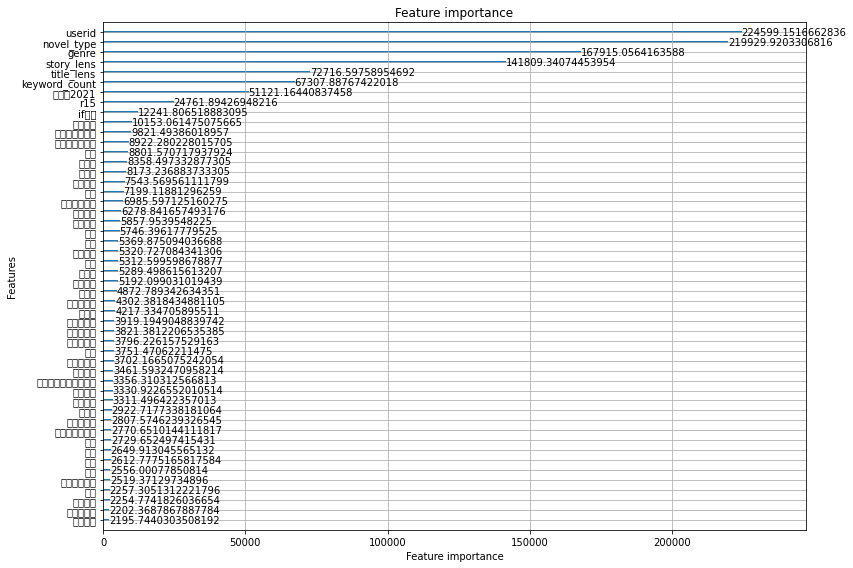

In [181]:
# 特徴量の重要度を確認

lgb.plot_importance(model, figsize=(12,8), max_num_features=50, importance_type='gain')
plt.tight_layout()
plt.show()

In [182]:
# 評価指標はlog lossだが、accuracyも見てみる

val_pred = model.predict(val_x, num_iteration=model.best_iteration)
val_pred_max = np.argmax(val_pred, axis=1)  # 最尤と判断したクラスの値にする
accuracy = sum(val_y == val_pred_max) / len(val_y)
print(accuracy)

0.6338395285584769


### 推論・投稿ファイル作成

In [183]:
test_pred = model.predict(test_x, num_iteration=model.best_iteration)

In [184]:
sub_df.iloc[:, 1:] = test_pred

In [185]:
sub_df.to_csv('./test_submission.csv', index=False)